# MIDI Music Generation - Generate (Tick-Based)

Generate piano music using a trained tick-based model.

**Requirements:** Trained model at `midi_data/best_model_tick.pt`  
**Output:** Generated MIDI files in `midi_data/generated/`

## 1. Setup

In [1]:
import random
from pathlib import Path


import numpy as np
import torch
import matplotlib.pyplot as plt

from midi_utils import (
    MIDI_CONFIG, NUM_PITCHES, TICK_FEATURES, SEQUENCE_LENGTH, SEED,
    TICKS_PER_BEAT, MAX_DURATION_TICKS, DEFAULT_TEMPO,
    get_device, MusicMamba, MusicLSTM,
    midi_to_tick_sequence, tick_sequence_to_midi, play_tick_sequence,
    generate_tick_music, create_random_tick_seed
)

random.seed(SEED)
np.random.seed(SEED)

DEVICE = get_device()

DATA_DIR = Path("./midi_data")
OUTPUT_DIR = DATA_DIR / "generated"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Tick config: {TICKS_PER_BEAT} ticks/beat, tempo={DEFAULT_TEMPO} BPM")

Using Apple Silicon MPS
Tick config: 4 ticks/beat, tempo=120 BPM


## 2. Load Trained Model

In [2]:
MODEL_PATH = DATA_DIR / "best_model_tick.pt"

if not MODEL_PATH.exists():
    raise FileNotFoundError(f"No model found at {MODEL_PATH}. Run midi_training.ipynb first!")

# Load checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=False)
model_type = checkpoint.get('model_type', 'mamba')
input_size = checkpoint.get('input_size', TICK_FEATURES)

# Create model
if model_type == "mamba":
    model = MusicMamba(input_size=input_size, d_model=256, d_state=16, n_layers=4, dropout=0.2).to(DEVICE)
else:
    model = MusicLSTM(input_size=input_size, hidden_size=512, num_layers=3, dropout=0.3).to(DEVICE)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded {model_type} model (tick-based)")
print(f"  Epoch: {checkpoint['epoch'] + 1}")
print(f"  Val loss: {checkpoint['val_loss']:.4f}")
print(f"  Input size: {input_size}")

Loaded mamba model (tick-based)
  Epoch: 4
  Val loss: 0.0211
  Input size: 176


## 3. Generate Music

In [3]:
# Generation parameters
DURATION_SECONDS = 15
TEMPERATURE = 0.8  # Lower=coherent, Higher=creative
TOP_K = 6  # Max notes per tick

# Calculate ticks for desired duration
# ticks = seconds × (ticks_per_beat × beats_per_second)
beats_per_second = DEFAULT_TEMPO / 60
num_ticks = int(DURATION_SECONDS * TICKS_PER_BEAT * beats_per_second)

# Create random seed
seed = create_random_tick_seed(SEQUENCE_LENGTH)

print(f"Generating {DURATION_SECONDS}s of music...")
print(f"  Temperature: {TEMPERATURE}, Top-k: {TOP_K}")
print(f"  Ticks to generate: {num_ticks}")

generated = generate_tick_music(model, seed, num_ticks, temperature=TEMPERATURE, top_k=TOP_K, device=DEVICE)
print(f"\nGenerated shape: {generated.shape} (ticks, pitches, channels)")

Generating 15s of music...
  Temperature: 0.8, Top-k: 6
  Ticks to generate: 120


Generating:   0%|          | 0/120 [00:00<?, ?it/s]


Generated shape: (184, 88, 2) (ticks, pitches, channels)


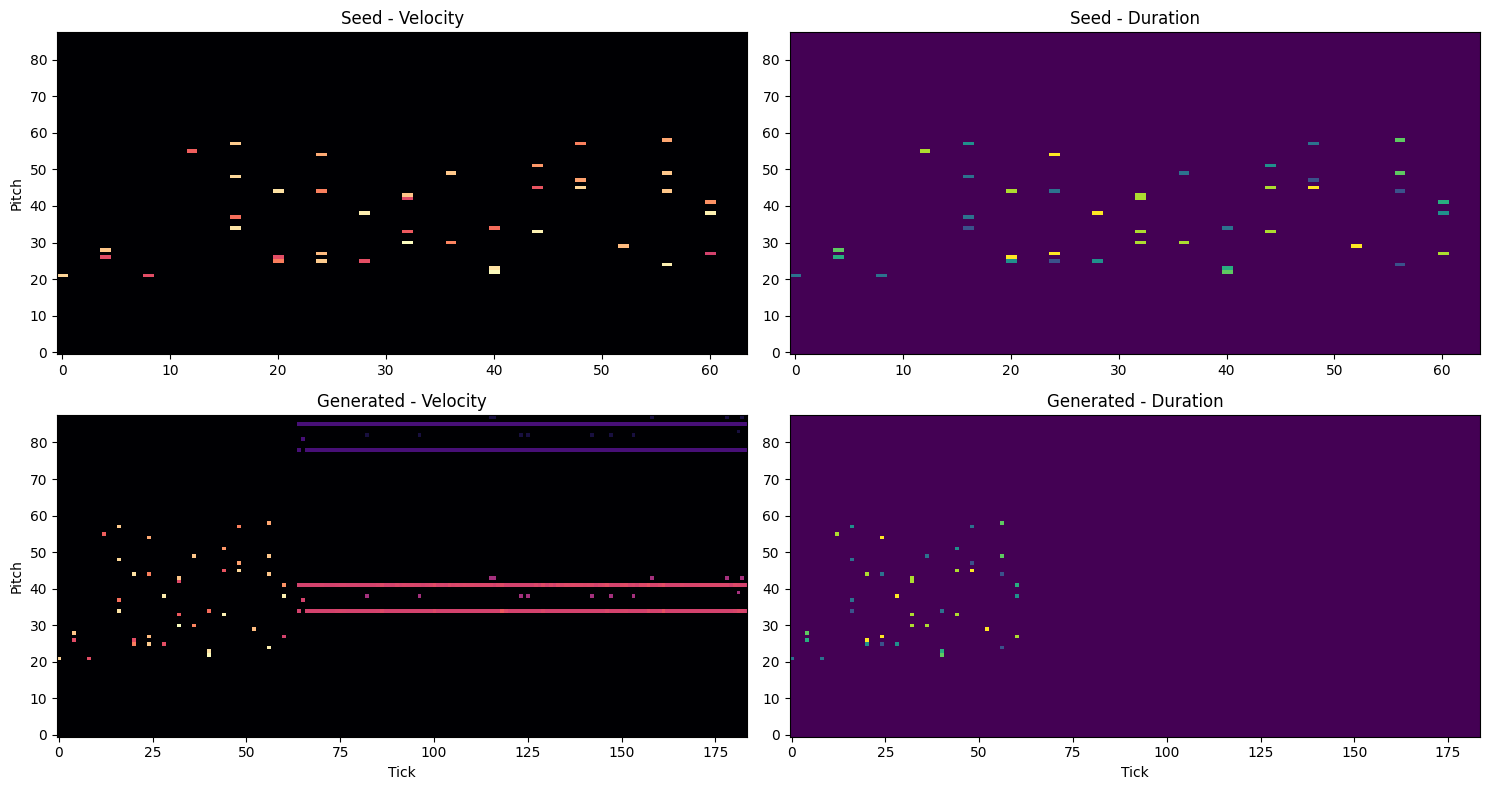

Generated: 120/120 ticks have notes (100%)


In [4]:
# Visualize velocity and duration channels
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Seed
axes[0, 0].imshow(seed[:, :, 0].T, aspect='auto', origin='lower', cmap='magma')
axes[0, 0].set_title('Seed - Velocity')
axes[0, 0].set_ylabel('Pitch')

axes[0, 1].imshow(seed[:, :, 1].T, aspect='auto', origin='lower', cmap='viridis')
axes[0, 1].set_title('Seed - Duration')

# Generated
axes[1, 0].imshow(generated[:, :, 0].T, aspect='auto', origin='lower', cmap='magma')
axes[1, 0].set_title('Generated - Velocity')
axes[1, 0].set_xlabel('Tick')
axes[1, 0].set_ylabel('Pitch')

axes[1, 1].imshow(generated[:, :, 1].T, aspect='auto', origin='lower', cmap='viridis')
axes[1, 1].set_title('Generated - Duration')
axes[1, 1].set_xlabel('Tick')

plt.tight_layout()
plt.show()

# Stats
gen_part = generated[SEQUENCE_LENGTH:]
active_ticks = np.sum(np.any(gen_part[:, :, 0] > 0, axis=1))
print(f"Generated: {active_ticks}/{len(gen_part)} ticks have notes ({100*active_ticks/len(gen_part):.0f}%)")

## 4. Play Generated Music

In [5]:
# Play the generated portion only (skip seed)
print(f"Playing GENERATED music only ({DURATION_SECONDS}s)...")
generated_only = generated[SEQUENCE_LENGTH:]
play_tick_sequence(generated_only)

Playing GENERATED music only (15s)...


In [6]:
# Play full output (seed + generated)
print("Playing FULL output (seed + generated)...")
play_tick_sequence(generated)

Playing FULL output (seed + generated)...


## 5. Export to MIDI

In [7]:
output_path = OUTPUT_DIR / "generated_tick.mid"
tick_sequence_to_midi(generated, output_path)
print(f"Saved to: {output_path}")

Saved to: midi_data/generated/generated_tick.mid


## 6. Explore Different Temperatures

In [8]:
temperatures = [0.5, 0.8, 1.0, 1.2]

for temp in temperatures:
    print(f"\nGenerating with temperature {temp}...")
    seed = create_random_tick_seed()
    gen = generate_tick_music(model, seed, num_ticks, temperature=temp, top_k=TOP_K, device=DEVICE)
    
    output_path = OUTPUT_DIR / f"generated_tick_temp_{temp}.mid"
    tick_sequence_to_midi(gen, output_path)
    print(f"  Saved: {output_path.name}")

print(f"\nAll files saved to: {OUTPUT_DIR}")


Generating with temperature 0.5...


Generating:   0%|          | 0/120 [00:00<?, ?it/s]

  Saved: generated_tick_temp_0.5.mid

Generating with temperature 0.8...


Generating:   0%|          | 0/120 [00:00<?, ?it/s]

  Saved: generated_tick_temp_0.8.mid

Generating with temperature 1.0...


Generating:   0%|          | 0/120 [00:00<?, ?it/s]

  Saved: generated_tick_temp_1.0.mid

Generating with temperature 1.2...


Generating:   0%|          | 0/120 [00:00<?, ?it/s]

  Saved: generated_tick_temp_1.2.mid

All files saved to: midi_data/generated


## 7. Generate from MIDI Seed (Optional)

Use an existing MIDI file as the seed for generation.

In [9]:
# Load a MIDI file as seed
seed_midi_path = DATA_DIR / "adl-piano-midi/Classical/American Modern Classical/Joseph Lamb/Contentment Rag.mid"

seed_roll = midi_to_tick_sequence(seed_midi_path)
if seed_roll is not None:
    print(f"Full tick sequence shape: {seed_roll.shape}")
    
    # Use SEQUENCE_LENGTH ticks as seed
    seed = seed_roll[:SEQUENCE_LENGTH]
    print(f"Seed shape: {seed.shape}")
    
    generated = generate_tick_music(model, seed, num_ticks, temperature=1.0, top_k=TOP_K, device=DEVICE)
    
    output_path = OUTPUT_DIR / "generated_from_midi_seed_tick.mid"
    tick_sequence_to_midi(generated, output_path)
    print(f"Saved to: {output_path}")
    
    # Play generated part only
    print(f"\nPlaying GENERATED part only:")
    generated_only = generated[SEQUENCE_LENGTH:]
    play_tick_sequence(generated_only)

Full tick sequence shape: (1170, 88, 2)
Seed shape: (64, 88, 2)


Generating:   0%|          | 0/120 [00:00<?, ?it/s]

Saved to: midi_data/generated/generated_from_midi_seed_tick.mid

Playing GENERATED part only:


## Tips

**Temperature guide:**
- `0.5` - Very coherent, possibly repetitive
- `0.8` - Balanced (recommended)
- `1.0` - More creative
- `1.2+` - Experimental, may be chaotic

**For better results:**
- Train for more epochs (50-100+)
- Use full dataset (remove MAX_FILES_PER_SPLIT limit)
- Try different seeds